In [1]:
import pandas as pd
import numpy as np
import re
import os
import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display_html

%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
# This function allows displaying of multiple data frames next to eachother. 
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
cred = os.environ.get('SQL')
engine = create_engine('mysql+pymysql://'+cred+'@localhost/books_project')

In [4]:
bx_books = pd.read_sql("bx_books", con=engine).drop("index", axis=1)
bx_book_r = pd.read_sql("bx_book_r", con=engine).drop("index", axis=1)
amazon32 = pd.read_sql("amazon32", con=engine).drop("index", axis=1)
gr_books_10k = pd.read_sql("gr_books_10k", con=engine).drop("index", axis=1)
gr_books_k = pd.read_sql("gr_books_k", con=engine)

In [5]:
# Remove 0 ratings as these are not actual ratings. They amount to about 1/3 of the dataset. 
bx_book_r = bx_book_r[bx_book_r["Book-Rating"]!=0]
bx_book_r

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


Count ratings for each rating

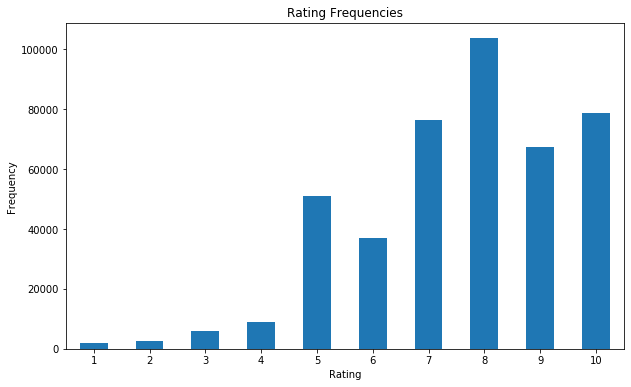

In [6]:
ax = bx_book_r["Book-Rating"].value_counts().sort_index().plot.bar(title="Rating Frequencies", figsize=(10,6), rot=0)
ax.set(xlabel="Rating", ylabel="Frequency")
ax

In [7]:
# 
bx_br = bx_book_r[["ISBN", "Book-Rating"]].groupby("ISBN").agg(["mean", "count"]).join(bx_books.set_index("ISBN")).dropna()
bx_br.columns = ["Av Rating", "Ratings Count", 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']
bx_br

C:\Users\fergu\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,Av Rating,Ratings Count,Book-Title,Book-Author,Year-Of-Publication,Publisher
ISBN,,,,,,
0000913154,8.0,1,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster
0001046438,9.0,1,Liar,Stephen Fry,0,Harpercollins Uk
000104687X,6.0,1,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers
0001047213,9.0,1,The Fighting Man,Gerald Seymour,1993,HarperCollins Publishers
0001047973,9.0,2,Brave New World,Aldous Huxley,1999,Trafalgar Square Publishing
...,...,...,...,...,...,...
B0001FZGPI,7.0,1,The Bonesetter's Daughter,Amy Tan,2001,Putnam Pub Group
B0001FZGRQ,9.0,1,The Clan of the Cave Bear,Jean M. Auel,2001,Crown Publishing Group
B0001GMSV2,8.0,2,Find Me,Rosie O'Donnell,2002,Warner Books


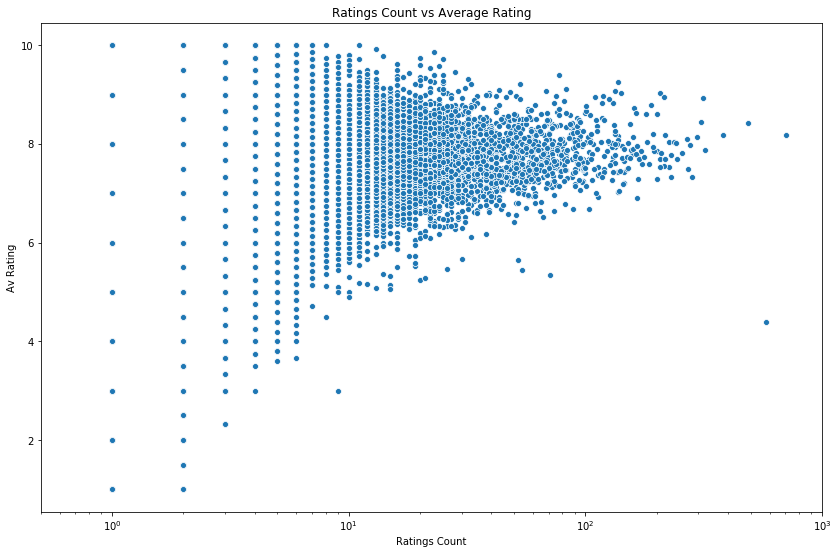

In [8]:
f, ax = plt.subplots(figsize=(14, 9))
ax.set(xscale="log", xlim=(0.5,1000))
ax.set_title("Ratings Count vs Average Rating")
sns.scatterplot("Ratings Count", "Av Rating", data=bx_br, ax=ax)

In [17]:
# Calculate an adjusted rating 2 stds from the mean of the sample - This is commented out because it takes a very long time to run and I don't want to run it unnecessarily. I instead ran it once and saved the output
# to an SQL/CSV file. In the end this value wasn't particularly helpful anyway. 
def LCB_rating(ISBN):
    rat = bx_book_r[bx_book_r["ISBN"]==ISBN]["Book-Rating"]
    return np.mean(rat)-2*np.std(rat)

bx_br["LCB rating"] = bx_br.index.map(lambda x: LCB_rating(x))

In [20]:
bx_br.to_csv("bx_br.csv")

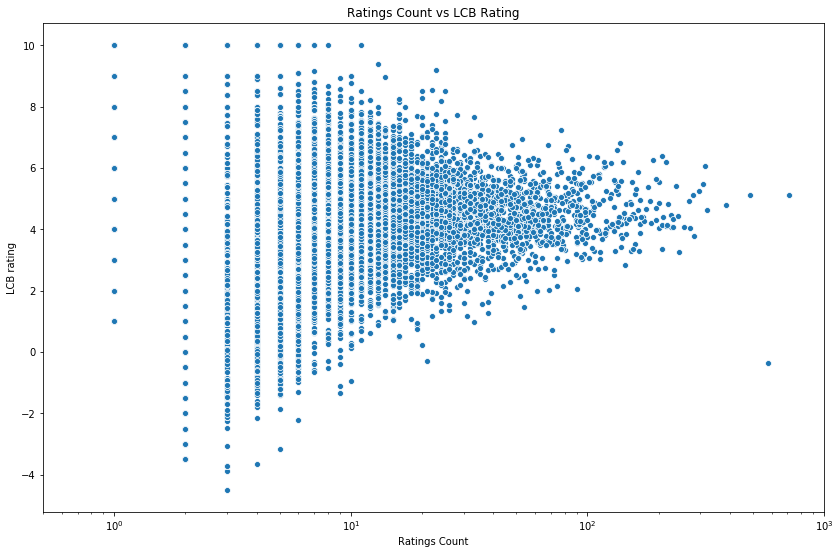

In [21]:
f, ax = plt.subplots(figsize=(14, 9))
ax.set(xscale="log", xlim=(0.5,1000))
ax.set_title("Ratings Count vs LCB Rating")
sns.scatterplot("Ratings Count", "LCB rating", data=bx_br, ax=ax)